In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 4.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
from math import sin, cos, pi
import cv2, os
from tqdm.auto import tqdm
from keras import layers, callbacks, utils, applications, optimizers
from keras.models import Sequential, Model, load_model
#from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
#import tensorflow as tf

In [ ]:
class config:           
    horizontal_flip = False
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True

    rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
    pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

    NUM_EPOCHS = 100
    BATCH_SIZE = 64

In [ ]:
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')
idlookup_data = pd.read_csv('IdLookupTable.csv')

In [ ]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [ ]:
train_data.head()  

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [ ]:
train_data.shape

(7049, 31)

In [ ]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
test_data.shape

(1783, 2)

In [ ]:
idlookup_data.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [ ]:
print("Length of train data:", len(train_data))

Length of train data: 7049


# **Base Model CNN WITH RESNET50**

In [ ]:
model = Sequential()
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(train_images, train_keypoints, epochs=200, batch_size=64, validation_split=0.15, callbacks=[earlyStopping, rlp])

**Our Observation Base Model show overfitting between accurcy and val accurcy**

#  **Check the Null Value** ⚛

In [ ]:
train_data.isnull().sum() 

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

**We observe the 68% of data is missing for keypoints** ✴

In [ ]:
clean_train_data = train_data.dropna()  
print("clean_train_data shape:", np.shape(clean_train_data))

unclean_train_data = train_data.fillna(method = 'ffill')  
print("unclean_train_data shape:", np.shape(unclean_train_data))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)


Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)


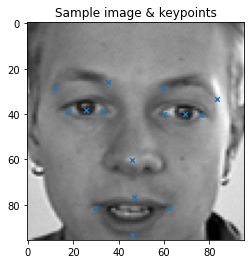

In [ ]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images:", np.shape(clean_train_images))

clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints:", np.shape(clean_train_keypoints))

test_images = load_images(test_data)
print("Shape of test_images:", np.shape(test_images))

train_images = clean_train_images        
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[19], clean_train_keypoints[19], axis, "Sample image & keypoints")

unclean_train_images = load_images(unclean_train_data)
print("Shape of unclean_train_images:", np.shape(unclean_train_images))

unclean_train_keypoints = load_keypoints(unclean_train_data)
print("Shape of unclean_train_keypoints:", np.shape(unclean_train_keypoints))


train_images = np.concatenate((train_images, unclean_train_images))
train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

**Augmentation** ⚛

In [ ]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if config.horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images:", np.shape(flipped_train_images))
    print("Shape of flipped_train_keypoints:", np.shape(flipped_train_keypoints))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[19], flipped_train_keypoints[19], axis, "Horizontally Flipped") 


Augmenting for angles (in degrees): 
12  -12  Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)


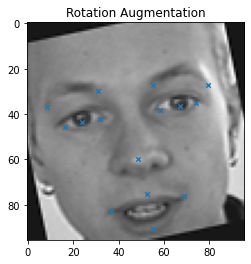

In [ ]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in config.rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

print()



if config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("Shape of rotated_train_images:", np.shape(rotated_train_images))
    print("Shape of rotated_train_keypoints:", np.shape(rotated_train_keypoints))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[19], rotated_train_keypoints[19], axis, "Rotation Augmentation")

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


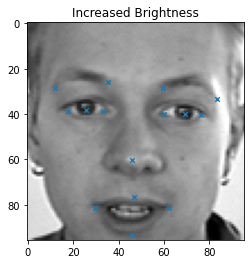

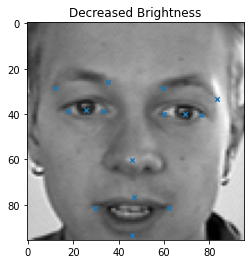

In [ ]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))


if config.brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print("Shape of altered_brightness_train_images:", np.shape(altered_brightness_train_images))
    print("Shape of altered_brightness_train_keypoints:", np.shape(altered_brightness_train_keypoints))
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[19], altered_brightness_train_keypoints[19], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+19], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+19], axis, "Decreased Brightness") 

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


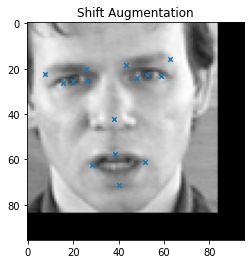

In [ ]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in config.pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints
if config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print("Shape of shifted_train_images:", np.shape(shifted_train_images))
    print("Shape of shifted_train_keypoints:", np.shape(shifted_train_keypoints))
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[19], shifted_train_keypoints[19], axis, "Shift Augmentation")

Shape of noisy_train_images: (2140, 96, 96, 1)


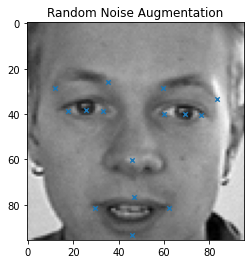

In [ ]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if config.random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print("Shape of noisy_train_images:", np.shape(noisy_train_images))
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[19], clean_train_keypoints[19], axis, "Random Noise Augmentation")

# **Visualize Train images & corresponding Keypoints**

Shape of final train_images: (26239, 96, 96, 1)
Shape of final train_keypoints: (26239, 30)

Clean Train Data: 


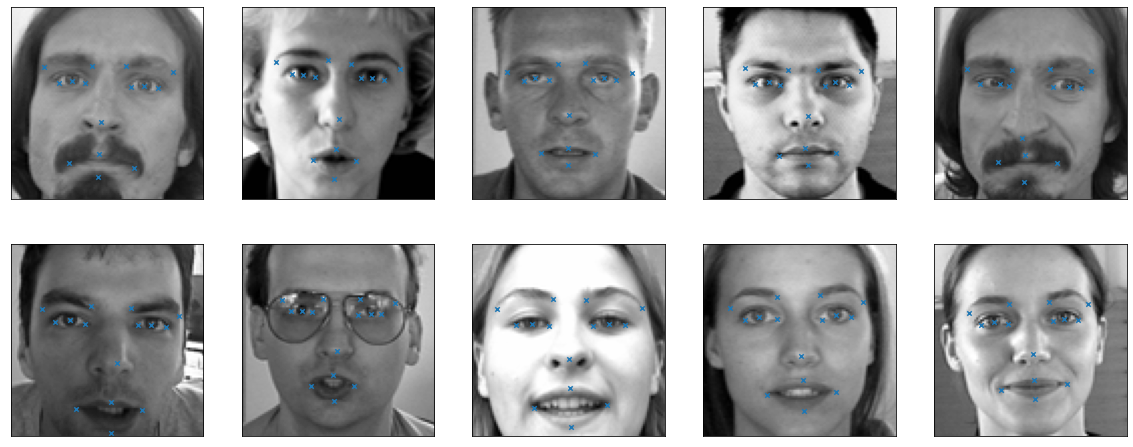

Unclean Train Data: 


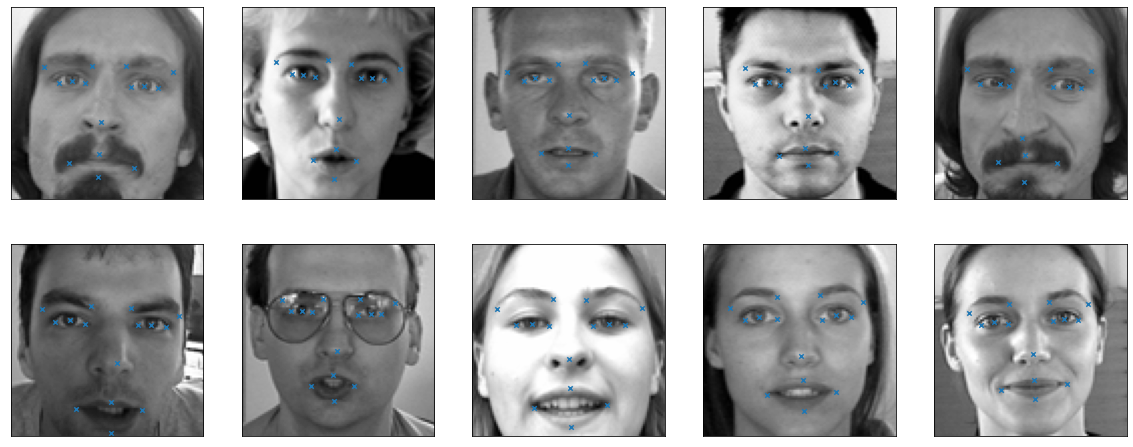

Rotation Augmentation: 


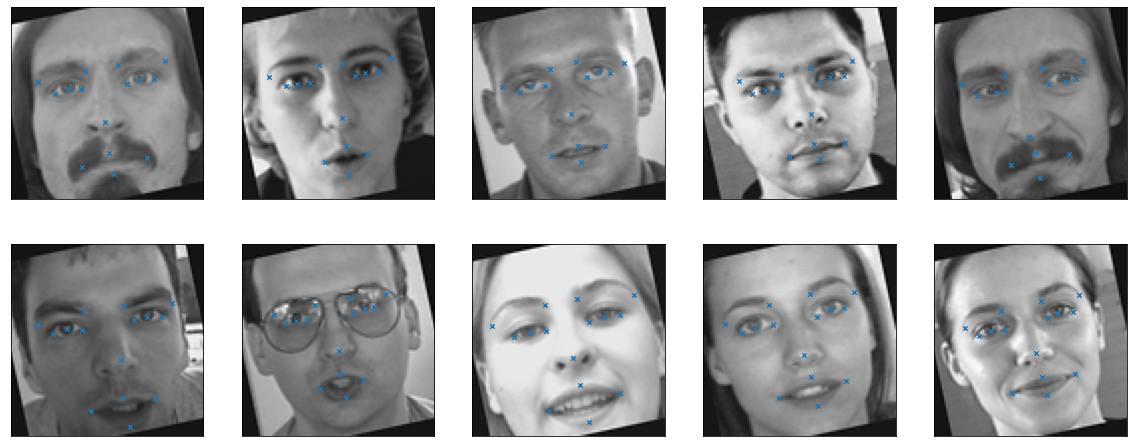

Brightness Augmentation: 


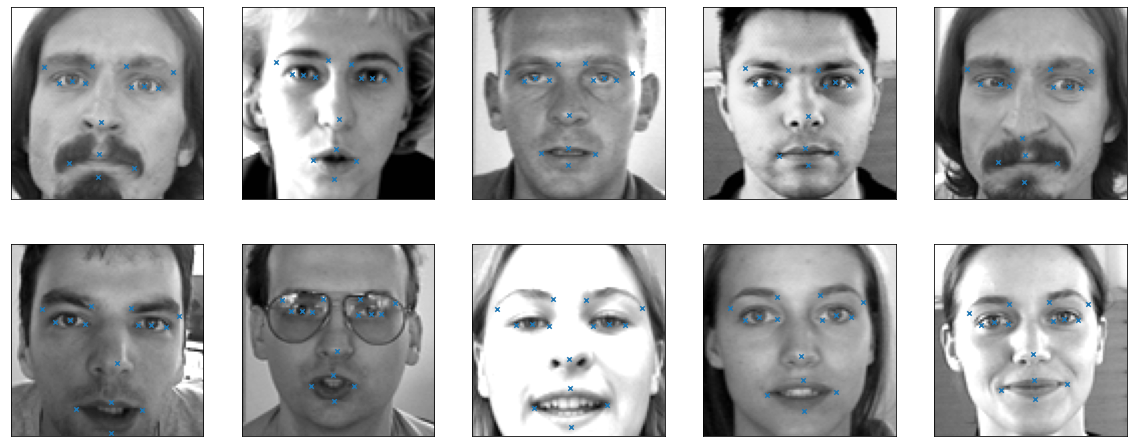

Shift Augmentation: 


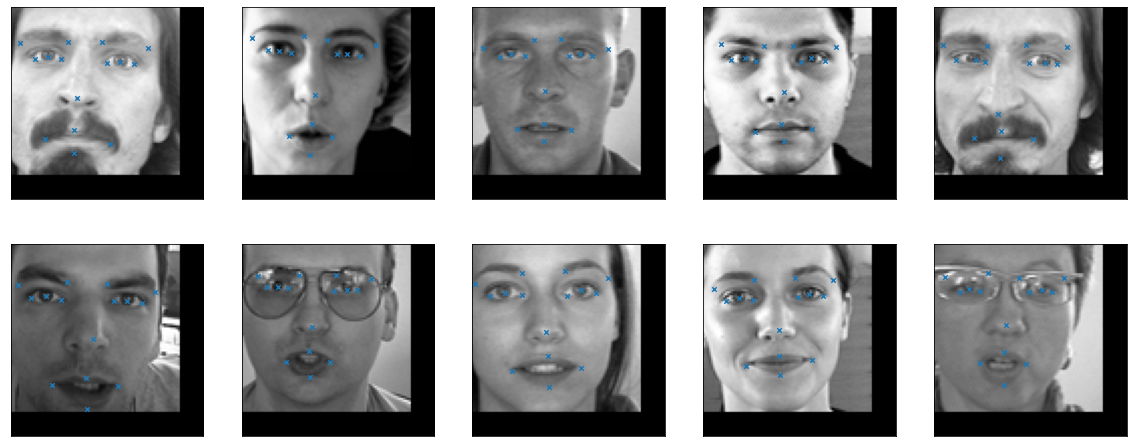

Random Noise Augmentation: 


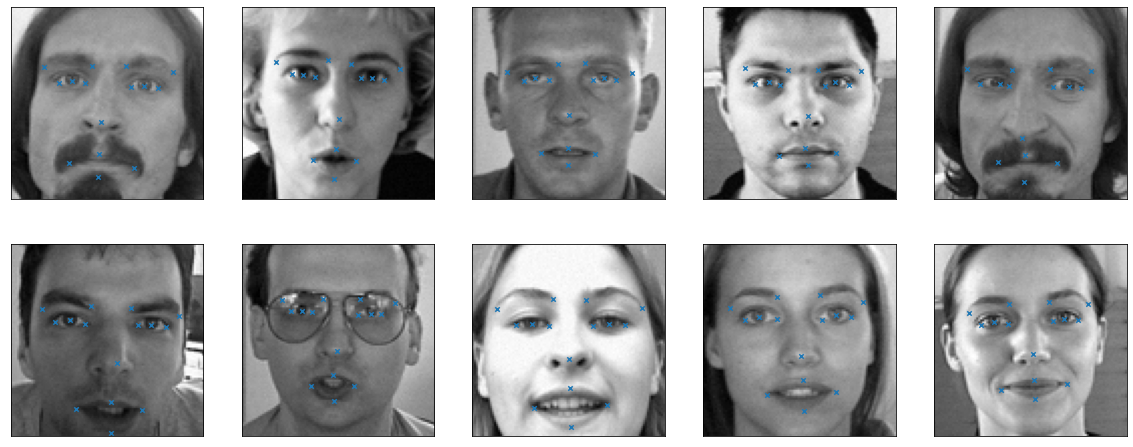

In [ ]:
print("Shape of final train_images:", np.shape(train_images))  
print("Shape of final train_keypoints:", np.shape(train_keypoints))

print("\nClean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

print("Unclean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
plt.show()

if config.horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if config.rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if config.brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if config.shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if config.random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

## **Model CNN WITH MOBILENETV2**

In [ ]:
model = Sequential()

pretrained_model = applications.mobilenet_v2.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')   

pretrained_model.trainable = True    

model.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model.add(layers.LeakyReLU(alpha = 0.1))
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())    
model.add(layers.Dropout(0.1))
model.add(layers.Dense(30))
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                           

# **Training the model**

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)              

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)


model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc']
)


history = model.fit(
    train_images, train_keypoints, epochs=int(1.5*config.NUM_EPOCHS), batch_size=config.BATCH_SIZE, 
    validation_split=0.05, callbacks=[early_stop, rlp]
)

Epoch 1/150
390/390 [==============================] - 75s 154ms/step - loss: 189.7021 - mae: 7.3778 - acc: 0.4883 - val_loss: 111.7203 - val_mae: 9.7675 - val_acc: 0.6189 - lr: 0.0010
Epoch 2/150
390/390 [==============================] - 57s 147ms/step - loss: 12.2932 - mae: 2.6006 - acc: 0.6298 - val_loss: 130.8143 - val_mae: 9.3646 - val_acc: 0.6189 - lr: 0.0010
Epoch 3/150
390/390 [==============================] - 57s 147ms/step - loss: 7.1596 - mae: 1.9583 - acc: 0.7273 - val_loss: 199.5139 - val_mae: 11.9666 - val_acc: 0.6159 - lr: 0.0010
Epoch 4/150
390/390 [==============================] - 58s 148ms/step - loss: 5.1854 - mae: 1.6650 - acc: 0.7653 - val_loss: 81.2208 - val_mae: 7.7360 - val_acc: 0.6311 - lr: 0.0010
Epoch 5/150
390/390 [==============================] - 57s 147ms/step - loss: 4.2190 - mae: 1.5051 - acc: 0.7881 - val_loss: 21.6845 - val_mae: 3.9746 - val_acc: 0.6593 - lr: 0.0010
Epoch 6/150
390/390 [==============================] - 57s 146ms/step - loss: 3.647

In [ ]:
model.save('face_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model.save('Desktop/face_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


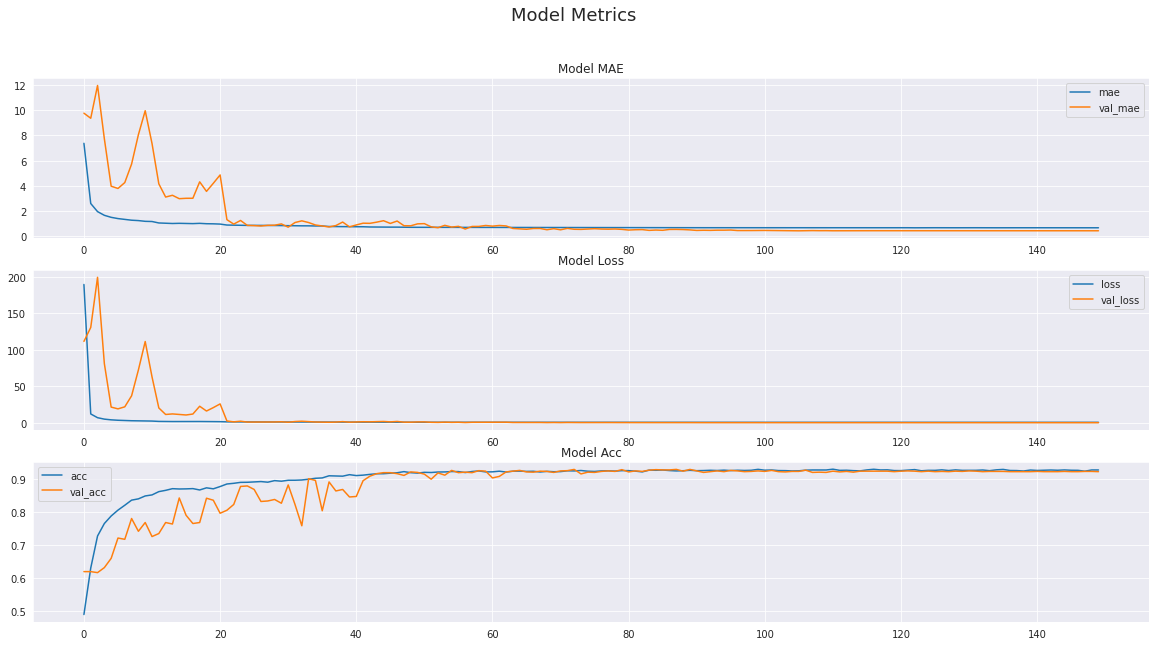

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['mae', 'val_mae']].plot(ax=ax[0])      
df[['loss', 'val_loss']].plot(ax=ax[1])
df[['acc', 'val_acc']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=12)     
ax[1].set_title('Model Loss', fontsize=12)
ax[2].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

**Predicting on Test Set**

In [ ]:
test_preds = model.predict(test_images)

# **Visualizing Test Predictions**

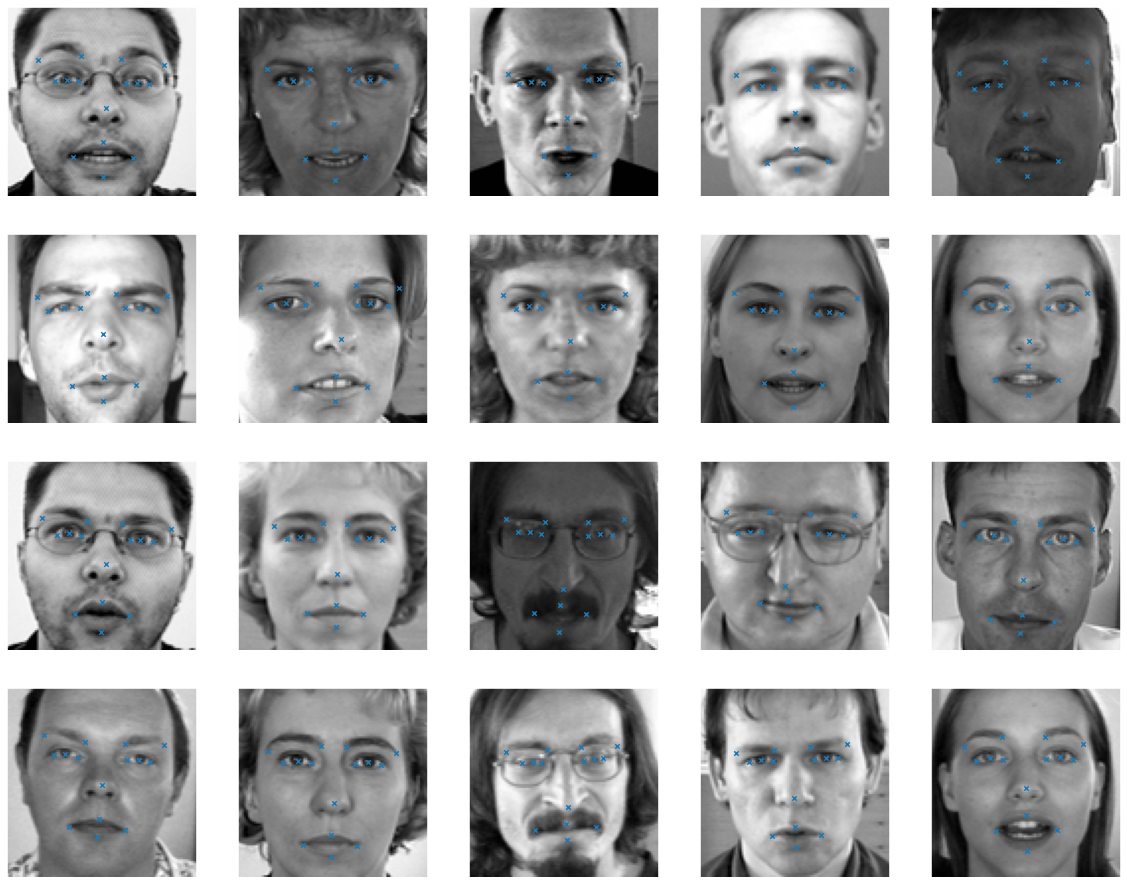

In [ ]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")